In [1]:
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
from keras import applications
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

datasetpath = 'dataset'
batch_size = 32
img_size = 128
model = applications.VGG16(include_top=False, weights='imagenet')

vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = vgg_data_gen.flow_from_directory(
        datasetpath + '/' + 'training',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False)  

cnn_features = model.predict_generator(train_generator, len(train_generator))

filename = 'cnn_features_training'
with open(filename, 'wb') as f:
          np.save(f, cnn_features)

val_generator = vgg_data_gen.flow_from_directory(
        datasetpath + '/' + "validation",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
cnn_features = model.predict_generator(val_generator, len(val_generator))
filename = 'cnn_features_validation'
with open(filename, 'wb') as f:
          np.save(f, cnn_features)


Using TensorFlow backend.


Found 2197 images belonging to 4 classes.
Found 612 images belonging to 4 classes.


In [42]:
import matplotlib.pyplot as plt
def draw_graph(History, arg): #arg = acc|loss
    plt.tight_layout()
    plt.plot(History.history[arg])
    val_arg = 'val_' + arg
    plt.plot(History.history[val_arg])
    plt.title('Model '+ arg)
    plt.ylabel(arg)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    plt.show()

In [41]:
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical

datagen_top = ImageDataGenerator(rescale=1. / 255)
    
nb_train_samples = len(train_generator.filenames)
num_classes = len(train_generator.class_indices)

np.save('class_indices.npy', train_generator.class_indices)
with open('cnn_features_training', 'rb') as f:
    train_data = np.load(f)

train_labels = train_generator.classes

train_labels = to_categorical(train_labels, num_classes=num_classes)

nb_validation_samples = len(val_generator.filenames)

with open('cnn_features_validation', 'rb') as f:
    validation_data = np.load(f)
    
validation_labels = val_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)


In [48]:
def create_model(nb_neurons,drop_out = 0.5):
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(nb_neurons, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Train on 2197 samples, validate on 612 samples
Epoch 1/150
2197/2197 [==============================] - 5s 2ms/step - loss: 3.1641 - acc: 0.7255 - val_loss: 1.5112 - val_acc: 0.8497
Epoch 2/150
2197/2197 [==============================] - 1s 658us/step - loss: 1.2400 - acc: 0.8666 - val_loss: 1.6400 - val_acc: 0.8186
Epoch 3/150
2197/2197 [==============================] - 1s 644us/step - loss: 0.6488 - acc: 0.9149 - val_loss: 1.0254 - val_acc: 0.8660
Epoch 4/150
2197/2197 [==============================] - 1s 631us/step - loss: 0.3760 - acc: 0.9486 - val_loss: 0.8810 - val_acc: 0.8431
Epoch 5/150
2197/2197 [==============================] - 2s 726us/step - loss: 0.2006 - acc: 0.9782 - val_loss: 0.8444 - val_acc: 0.8513
Epoch 6/150
2197/2197 [==============================] - 2s 782us/step - loss: 0.1395 - acc: 0.9845 - val_loss: 0.8915 - val_acc: 0.8578
Epoch 7/150
2197/2197 [==============================] - 2s 743us/step - loss: 0.1122 - acc: 0.9918 - val_loss: 0.8137 - val_acc: 0.8

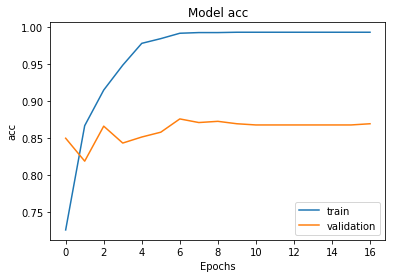

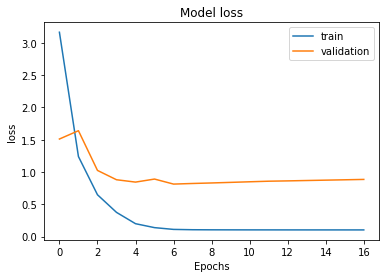

Train on 2197 samples, validate on 612 samples
Epoch 1/150
2197/2197 [==============================] - 6s 3ms/step - loss: 6.0497 - acc: 0.5940 - val_loss: 3.7385 - val_acc: 0.7418
Epoch 2/150
2197/2197 [==============================] - 3s 1ms/step - loss: 2.9810 - acc: 0.7915 - val_loss: 2.9420 - val_acc: 0.7990
Epoch 3/150
2197/2197 [==============================] - 3s 1ms/step - loss: 2.3249 - acc: 0.8380 - val_loss: 2.6521 - val_acc: 0.8252
Epoch 4/150
2197/2197 [==============================] - 3s 1ms/step - loss: 2.1144 - acc: 0.8553 - val_loss: 2.5350 - val_acc: 0.8268
Epoch 5/150
2197/2197 [==============================] - 3s 1ms/step - loss: 1.6591 - acc: 0.8862 - val_loss: 2.7014 - val_acc: 0.8137
Epoch 6/150
2197/2197 [==============================] - 3s 1ms/step - loss: 1.6872 - acc: 0.8848 - val_loss: 2.4372 - val_acc: 0.8350
Epoch 7/150
2197/2197 [==============================] - 3s 1ms/step - loss: 1.7479 - acc: 0.8812 - val_loss: 3.0454 - val_acc: 0.8023
Epoch 8/

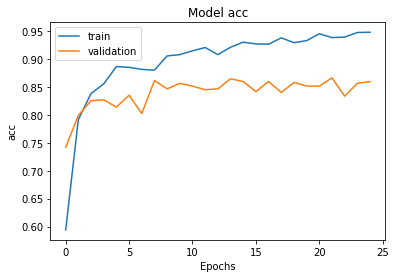

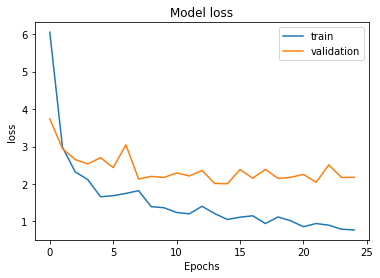

Train on 2197 samples, validate on 612 samples
Epoch 1/150
2197/2197 [==============================] - 8s 4ms/step - loss: 10.6221 - acc: 0.3332 - val_loss: 10.3026 - val_acc: 0.3546
Epoch 2/150
2197/2197 [==============================] - 5s 2ms/step - loss: 9.8124 - acc: 0.3860 - val_loss: 9.5648 - val_acc: 0.4052
Epoch 3/150
2197/2197 [==============================] - 4s 2ms/step - loss: 9.4659 - acc: 0.4101 - val_loss: 10.4067 - val_acc: 0.3448
Epoch 4/150
2197/2197 [==============================] - 5s 2ms/step - loss: 9.2513 - acc: 0.4238 - val_loss: 9.1446 - val_acc: 0.4248
Epoch 5/150
2197/2197 [==============================] - 5s 2ms/step - loss: 9.1492 - acc: 0.4301 - val_loss: 9.1218 - val_acc: 0.4330
Epoch 6/150
2197/2197 [==============================] - 4s 2ms/step - loss: 7.7237 - acc: 0.5148 - val_loss: 5.7772 - val_acc: 0.6356
Epoch 7/150
2197/2197 [==============================] - 4s 2ms/step - loss: 4.4684 - acc: 0.7151 - val_loss: 3.2854 - val_acc: 0.7925
Epoch

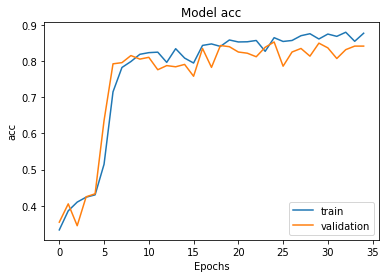

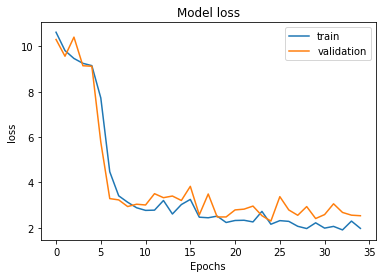

Train on 2197 samples, validate on 612 samples
Epoch 1/150
2197/2197 [==============================] - 5s 2ms/step - loss: 6.1038 - acc: 0.5580 - val_loss: 2.4870 - val_acc: 0.7843
Epoch 2/150
2197/2197 [==============================] - 1s 681us/step - loss: 3.0113 - acc: 0.7551 - val_loss: 1.7509 - val_acc: 0.8350
Epoch 3/150
2197/2197 [==============================] - 2s 744us/step - loss: 1.5657 - acc: 0.8002 - val_loss: 1.0330 - val_acc: 0.8333
Epoch 4/150
2197/2197 [==============================] - 2s 724us/step - loss: 1.0235 - acc: 0.7861 - val_loss: 0.9033 - val_acc: 0.7974
Epoch 5/150
2197/2197 [==============================] - 2s 718us/step - loss: 0.7171 - acc: 0.7838 - val_loss: 0.7202 - val_acc: 0.8121
Epoch 6/150
2197/2197 [==============================] - 2s 793us/step - loss: 0.6068 - acc: 0.8143 - val_loss: 0.6856 - val_acc: 0.8513
Epoch 7/150
2197/2197 [==============================] - 2s 793us/step - loss: 0.5250 - acc: 0.8421 - val_loss: 0.5952 - val_acc: 0.8

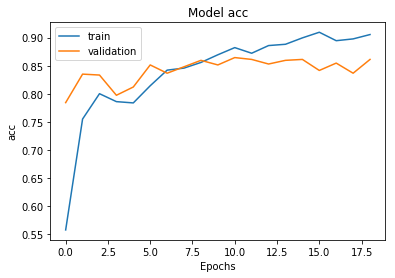

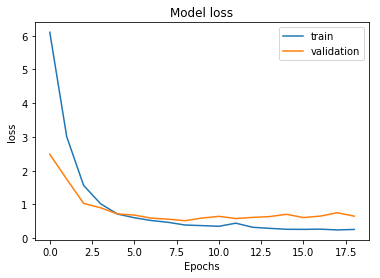

Train on 2197 samples, validate on 612 samples
Epoch 1/150
2197/2197 [==============================] - 6s 3ms/step - loss: 6.3211 - acc: 0.5585 - val_loss: 3.2687 - val_acc: 0.7647
Epoch 2/150
2197/2197 [==============================] - 3s 1ms/step - loss: 3.3652 - acc: 0.7651 - val_loss: 3.3437 - val_acc: 0.7712
Epoch 3/150
2197/2197 [==============================] - 3s 1ms/step - loss: 3.1166 - acc: 0.7815 - val_loss: 2.4368 - val_acc: 0.8350
Epoch 4/150
2197/2197 [==============================] - 3s 1ms/step - loss: 2.4202 - acc: 0.8211 - val_loss: 2.1234 - val_acc: 0.8497
Epoch 5/150
2197/2197 [==============================] - 3s 1ms/step - loss: 2.0156 - acc: 0.8525 - val_loss: 1.8738 - val_acc: 0.8578
Epoch 6/150
2197/2197 [==============================] - 3s 1ms/step - loss: 2.0420 - acc: 0.8425 - val_loss: 1.7744 - val_acc: 0.8529
Epoch 7/150
2197/2197 [==============================] - 3s 1ms/step - loss: 1.6765 - acc: 0.8744 - val_loss: 1.7856 - val_acc: 0.8578
Epoch 8/

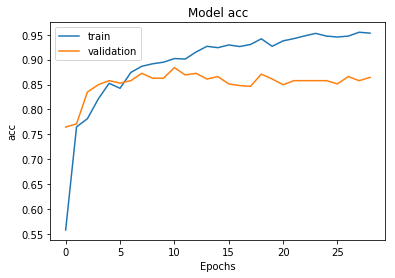

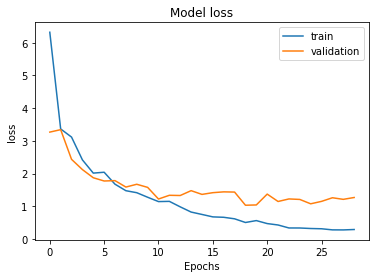

Train on 2197 samples, validate on 612 samples
Epoch 1/150
2197/2197 [==============================] - 8s 4ms/step - loss: 5.9748 - acc: 0.5954 - val_loss: 3.6370 - val_acc: 0.7565
Epoch 2/150
2197/2197 [==============================] - 5s 2ms/step - loss: 3.8968 - acc: 0.7396 - val_loss: 2.3529 - val_acc: 0.8350
Epoch 3/150
2197/2197 [==============================] - 5s 2ms/step - loss: 3.1189 - acc: 0.7902 - val_loss: 2.6371 - val_acc: 0.8219
Epoch 4/150
2197/2197 [==============================] - 5s 2ms/step - loss: 2.9301 - acc: 0.8088 - val_loss: 2.4238 - val_acc: 0.8333
Epoch 5/150
2197/2197 [==============================] - 5s 2ms/step - loss: 2.9234 - acc: 0.8102 - val_loss: 2.4850 - val_acc: 0.8366
Epoch 6/150
2197/2197 [==============================] - 5s 2ms/step - loss: 2.6246 - acc: 0.8302 - val_loss: 3.0547 - val_acc: 0.7974
Epoch 7/150
2197/2197 [==============================] - 4s 2ms/step - loss: 2.5211 - acc: 0.8343 - val_loss: 2.7974 - val_acc: 0.8137
Epoch 8/

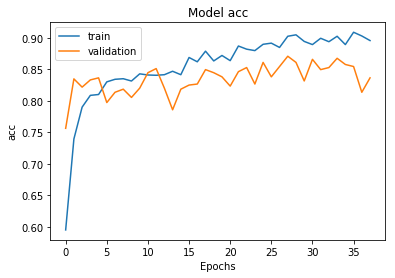

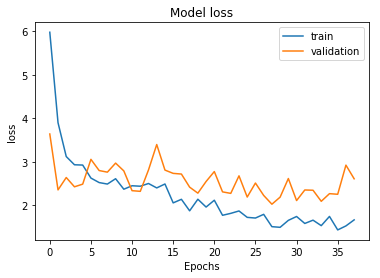

In [49]:

for drop_out in [0,0.5]:
    for nb_neurons in [64,128,256]:
        model = create_model(nb_neurons, drop_out)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10)

        history = model.fit(train_data, train_labels,
                            epochs=150,
                            batch_size=batch_size,
                            validation_data=(validation_data, validation_labels),
                            callbacks=[early_stopping]
                            )
        (eval_loss, eval_accuracy) = model.evaluate(
           validation_data, validation_labels, batch_size=batch_size, verbose=1)
        print("Dropout:")
        print(drop_out)
        print("Neurons:")
        print(nb_neurons)
        print("Accuracy: {:.2f}%".format(eval_accuracy * 100))
        print("Loss: {}".format(eval_loss))

        draw_graph(history, 'acc')
        draw_graph(history, 'loss')

In [50]:
def create_model2(nb_neurons1,nb_neurons2,drop_out = 0.5):
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(nb_neurons1, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(nb_neurons2, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Train on 2197 samples, validate on 612 samples
Epoch 1/150
2197/2197 [==============================] - 5s 2ms/step - loss: 2.7501 - acc: 0.7051 - val_loss: 1.8384 - val_acc: 0.7810
Epoch 2/150
2197/2197 [==============================] - 2s 915us/step - loss: 1.0886 - acc: 0.8789 - val_loss: 1.2802 - val_acc: 0.8415
Epoch 3/150
2197/2197 [==============================] - 2s 846us/step - loss: 0.6481 - acc: 0.9231 - val_loss: 1.1728 - val_acc: 0.8595
Epoch 4/150
2197/2197 [==============================] - 2s 929us/step - loss: 0.5273 - acc: 0.9399 - val_loss: 1.2258 - val_acc: 0.8464
Epoch 5/150
2197/2197 [==============================] - 2s 931us/step - loss: 0.3048 - acc: 0.9677 - val_loss: 1.1332 - val_acc: 0.8529
Epoch 6/150
2197/2197 [==============================] - 2s 1ms/step - loss: 0.3154 - acc: 0.9704 - val_loss: 1.5146 - val_acc: 0.8301
Epoch 7/150
2197/2197 [==============================] - 2s 863us/step - loss: 0.2500 - acc: 0.9745 - val_loss: 1.0850 - val_acc: 0.854

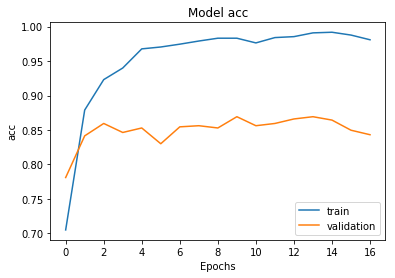

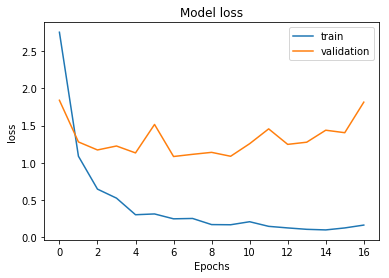

Train on 2197 samples, validate on 612 samples
Epoch 1/150
2197/2197 [==============================] - 6s 3ms/step - loss: 7.1145 - acc: 0.5353 - val_loss: 5.6252 - val_acc: 0.6389
Epoch 2/150
2197/2197 [==============================] - 3s 2ms/step - loss: 5.4267 - acc: 0.6486 - val_loss: 5.7791 - val_acc: 0.6324
Epoch 3/150
2197/2197 [==============================] - 3s 1ms/step - loss: 5.3619 - acc: 0.6563 - val_loss: 5.4041 - val_acc: 0.6520
Epoch 4/150
2197/2197 [==============================] - 3s 2ms/step - loss: 5.0886 - acc: 0.6755 - val_loss: 5.2767 - val_acc: 0.6667
Epoch 5/150
2197/2197 [==============================] - 3s 2ms/step - loss: 4.9835 - acc: 0.6855 - val_loss: 5.4870 - val_acc: 0.6520
Epoch 6/150
2197/2197 [==============================] - 4s 2ms/step - loss: 5.0756 - acc: 0.6791 - val_loss: 5.6487 - val_acc: 0.6422
Epoch 7/150
2197/2197 [==============================] - 4s 2ms/step - loss: 5.1395 - acc: 0.6777 - val_loss: 5.8657 - val_acc: 0.6275
Epoch 8/

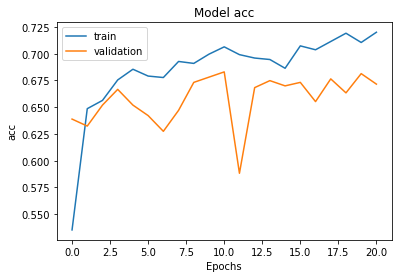

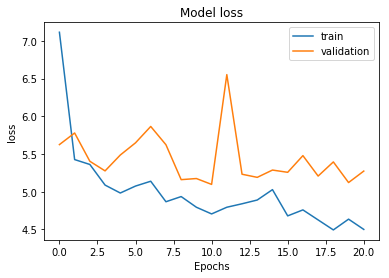

Train on 2197 samples, validate on 612 samples
Epoch 1/150
2197/2197 [==============================] - 11s 5ms/step - loss: 11.7828 - acc: 0.2649 - val_loss: 12.1939 - val_acc: 0.2435
Epoch 2/150
2197/2197 [==============================] - 6s 3ms/step - loss: 11.8410 - acc: 0.2654 - val_loss: 12.1939 - val_acc: 0.2435
Epoch 3/150
2197/2197 [==============================] - 7s 3ms/step - loss: 11.8410 - acc: 0.2654 - val_loss: 12.1939 - val_acc: 0.2435
Epoch 4/150
2197/2197 [==============================] - 6s 3ms/step - loss: 11.8410 - acc: 0.2654 - val_loss: 12.1939 - val_acc: 0.2435
Epoch 5/150
2197/2197 [==============================] - 7s 3ms/step - loss: 11.8410 - acc: 0.2654 - val_loss: 12.1939 - val_acc: 0.2435
Epoch 6/150
2197/2197 [==============================] - 6s 3ms/step - loss: 11.8410 - acc: 0.2654 - val_loss: 12.1939 - val_acc: 0.2435
Epoch 7/150
2197/2197 [==============================] - 8s 4ms/step - loss: 11.8410 - acc: 0.2654 - val_loss: 12.1939 - val_acc: 

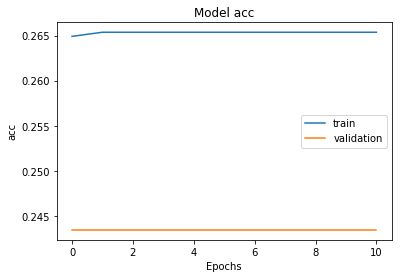

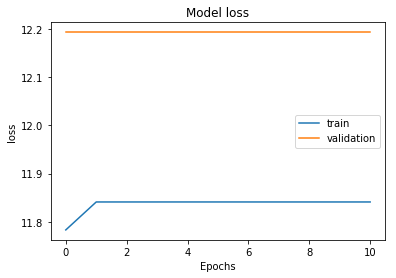

Train on 2197 samples, validate on 612 samples
Epoch 1/150
2197/2197 [==============================] - 5s 2ms/step - loss: 8.1051 - acc: 0.4333 - val_loss: 4.2238 - val_acc: 0.6879
Epoch 2/150
2197/2197 [==============================] - 2s 938us/step - loss: 6.5381 - acc: 0.5544 - val_loss: 2.6192 - val_acc: 0.8023
Epoch 3/150
2197/2197 [==============================] - 2s 932us/step - loss: 5.1342 - acc: 0.6491 - val_loss: 2.9016 - val_acc: 0.7892
Epoch 4/150
2197/2197 [==============================] - 2s 1ms/step - loss: 4.2163 - acc: 0.7087 - val_loss: 2.6437 - val_acc: 0.8186
Epoch 5/150
2197/2197 [==============================] - 3s 1ms/step - loss: 3.8830 - acc: 0.7269 - val_loss: 2.5880 - val_acc: 0.8154
Epoch 6/150
2197/2197 [==============================] - 3s 1ms/step - loss: 3.6620 - acc: 0.7447 - val_loss: 2.4087 - val_acc: 0.8203
Epoch 7/150
2197/2197 [==============================] - 3s 1ms/step - loss: 3.4029 - acc: 0.7665 - val_loss: 2.5716 - val_acc: 0.8219
Epoc

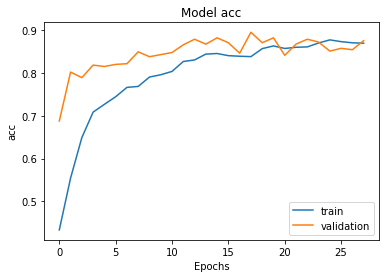

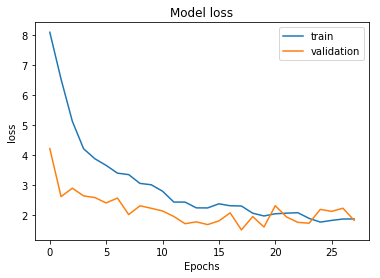

Train on 2197 samples, validate on 612 samples
Epoch 1/150
2197/2197 [==============================] - 7s 3ms/step - loss: 8.6186 - acc: 0.4256 - val_loss: 6.1344 - val_acc: 0.5948
Epoch 2/150
2197/2197 [==============================] - 3s 1ms/step - loss: 6.7973 - acc: 0.5553 - val_loss: 6.8597 - val_acc: 0.5572
Epoch 3/150
2197/2197 [==============================] - 4s 2ms/step - loss: 5.2265 - acc: 0.6600 - val_loss: 3.1477 - val_acc: 0.7892
Epoch 4/150
2197/2197 [==============================] - 3s 1ms/step - loss: 4.9680 - acc: 0.6700 - val_loss: 3.4038 - val_acc: 0.7745
Epoch 5/150
2197/2197 [==============================] - 4s 2ms/step - loss: 3.9873 - acc: 0.7360 - val_loss: 2.9046 - val_acc: 0.8072
Epoch 6/150
2197/2197 [==============================] - 4s 2ms/step - loss: 3.8106 - acc: 0.7487 - val_loss: 3.2023 - val_acc: 0.7859
Epoch 7/150
2197/2197 [==============================] - 4s 2ms/step - loss: 4.0731 - acc: 0.7365 - val_loss: 3.0152 - val_acc: 0.8039
Epoch 8/

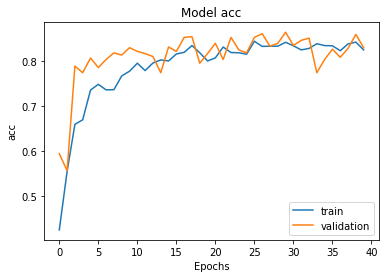

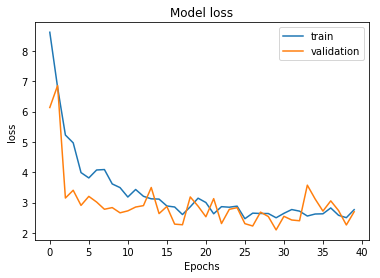

Train on 2197 samples, validate on 612 samples
Epoch 1/150
2197/2197 [==============================] - 11s 5ms/step - loss: 8.3045 - acc: 0.4461 - val_loss: 2.9795 - val_acc: 0.7876
Epoch 2/150
2197/2197 [==============================] - 6s 3ms/step - loss: 5.0968 - acc: 0.6668 - val_loss: 4.4105 - val_acc: 0.7190
Epoch 3/150
2197/2197 [==============================] - 7s 3ms/step - loss: 4.4970 - acc: 0.7073 - val_loss: 3.4575 - val_acc: 0.7745
Epoch 4/150
2197/2197 [==============================] - 6s 3ms/step - loss: 4.1239 - acc: 0.7315 - val_loss: 3.5856 - val_acc: 0.7696
Epoch 5/150
2197/2197 [==============================] - 6s 3ms/step - loss: 4.0709 - acc: 0.7387 - val_loss: 4.7272 - val_acc: 0.6944
Epoch 6/150
2197/2197 [==============================] - 7s 3ms/step - loss: 3.9143 - acc: 0.7506 - val_loss: 3.4658 - val_acc: 0.7810
Epoch 7/150
2197/2197 [==============================] - 8s 4ms/step - loss: 4.1383 - acc: 0.7374 - val_loss: 3.3927 - val_acc: 0.7843
Epoch 8

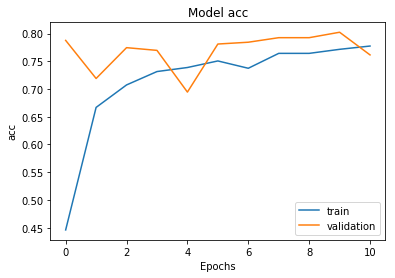

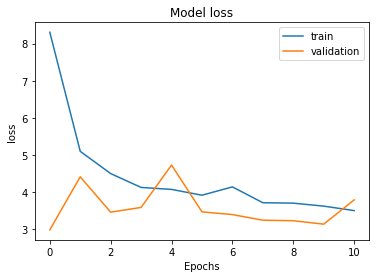

In [57]:
for drop_out in [0,0.5]:
    for nb_neurons in [128,256,512]:
        model = create_model2(nb_neurons, nb_neurons//2, drop_out)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10)

        history = model.fit(train_data, train_labels,
                            epochs=150,
                            batch_size=batch_size,
                            validation_data=(validation_data, validation_labels),
                            callbacks=[early_stopping]
                            )
        (eval_loss, eval_accuracy) = model.evaluate(
           validation_data, validation_labels, batch_size=batch_size, verbose=1)
        print("Dropout:")
        print(drop_out)
        print("Neurons:")
        print(nb_neurons)
        print("Accuracy: {:.2f}%".format(eval_accuracy * 100))
        print("Loss: {}".format(eval_loss))

        draw_graph(history, 'acc')
        draw_graph(history, 'loss')

The maximum accuracy (87,58%) with 3 fully-connected layers: 1st 128 neurons, 2nd - 64, 3rd - 4. And with dropout between them.
So, we will take this architecture for our final model. But 2 fully-connected layers (1st -128, 2nd - 4, dropout - 0.5) also have quite high accuracy(86,44%), so we will focus more to tune convolutional layers in our model. 